<a href="https://colab.research.google.com/github/Bx1Rob/DATA71200-Final-Project/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA 7200 PROJECT**

**Project Goal**



1.   Predict the likelihood of working in the nonprofit sector by sex and education (maybe disability and by region as well)
2.   Identify how demographic patterns align with nonprofit employment

## *Connect Part 1*

Step 1: Load your data, including testing/training split from Project 1.
* Your testing and training split should be balanced
* Your data should be clean and missing data should be addressed

Step 2: (If not already done in Project 1) Prepare your data
* Make sure that all your appropriate variables are converted to categorical variables (as ordinal or one hot)
*Perform any necessary feature scaling

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj
From (redirected): https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj&confirm=t&uuid=49f1f933-024a-4810-a873-d09ac9002e0b
To: /content/psam_pusb.csv
100%|██████████| 2.23G/2.23G [00:24<00:00, 89.9MB/s]


Loaded shape: (3435956, 6)


,AGEP,COW,SCHL,SEX,DIS,ESR
0,29,1.0,17.0,1,2,1.0
1,33,NaN,14.0,2,2,6.0
2,18,1.0,19.0,2,2,1.0
3,49,1.0,17.0,1,2,6.0
4,64,1.0,19.0,1,2,1.0


After 18+ & employed filter: (1576914, 6)
Train size: (1182685, 4)  Test size: (394229, 4)
Train class balance:
 nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64
Test class balance:
 nonprofit_worker
0    0.892235
1    0.107765
Name: proportion, dtype: float64
DataFrame.info():
<class 'pandas.core.frame.DataFrame'>
Index: 1182685 entries, 2550531 to 1921774
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   AGEP              1182685 non-null  int64  
 1   SEX               1182685 non-null  int64  
 2   SCHL              1182685 non-null  float64
 3   DIS               1182685 non-null  int64  
 4   nonprofit_worker  1182685 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 54.1 MB

DataFrame.describe():


,AGEP,SEX,SCHL,DIS,nonprofit_worker
count,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06
mean,4.425062e+01,1.484018e+00,1.890472e+01,1.927300e+00,1.077658e-01
std,1.493846e+01,4.997447e-01,3.134828e+00,2.596433e-01,3.100845e-01
min,1.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.200000e+01,1.000000e+00,1.600000e+01,2.000000e+00,0.000000e+00
50%,4.400000e+01,1.000000e+00,1.900000e+01,2.000000e+00,0.000000e+00
75%,5.600000e+01,2.000000e+00,2.100000e+01,2.000000e+00,0.000000e+00
max,9.500000e+01,2.000000e+00,2.400000e+01,2.000000e+00,1.000000e+00


Saved to Drive:
 - pums_train_clean.csv
 - pums_test_clean.csv


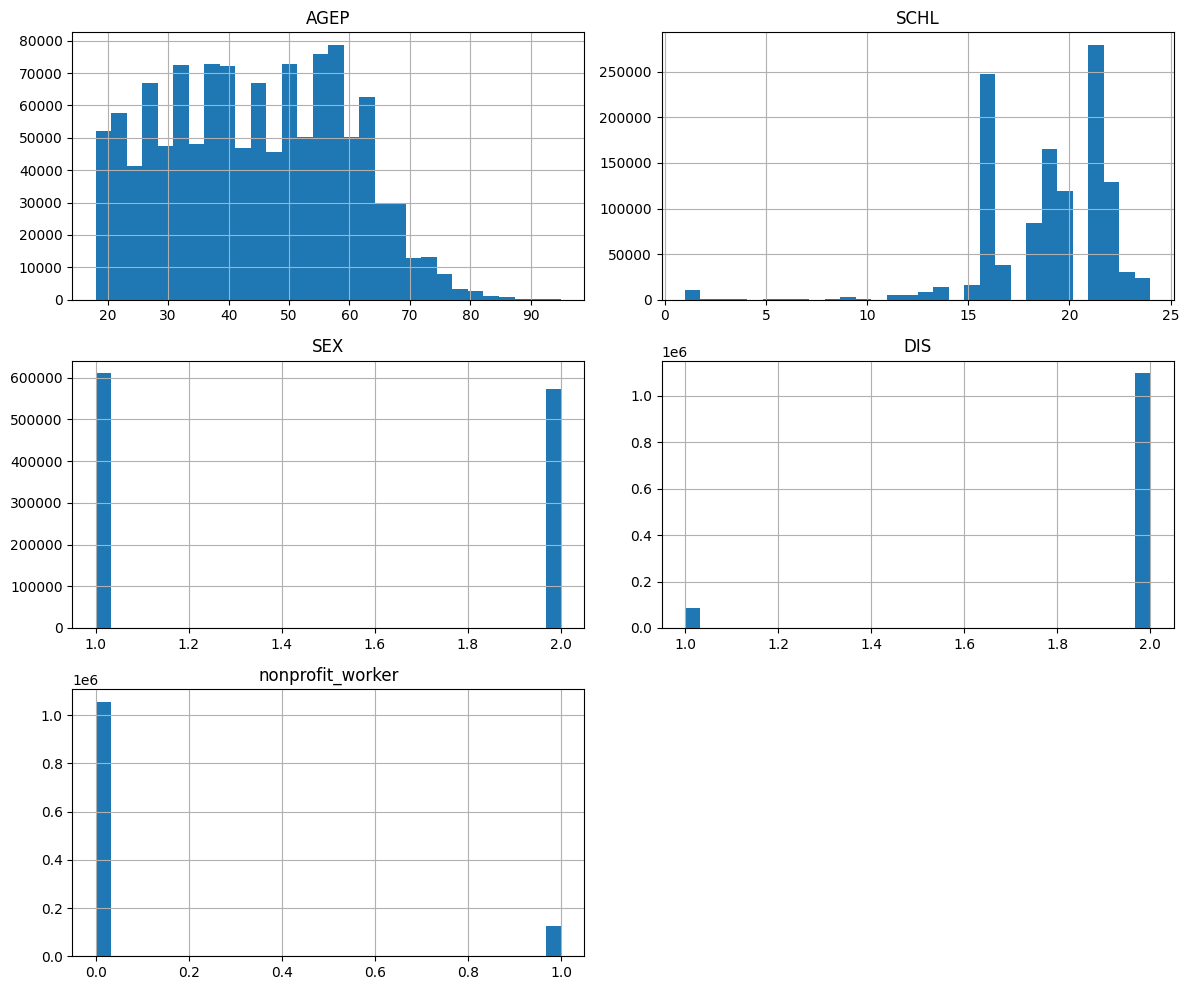

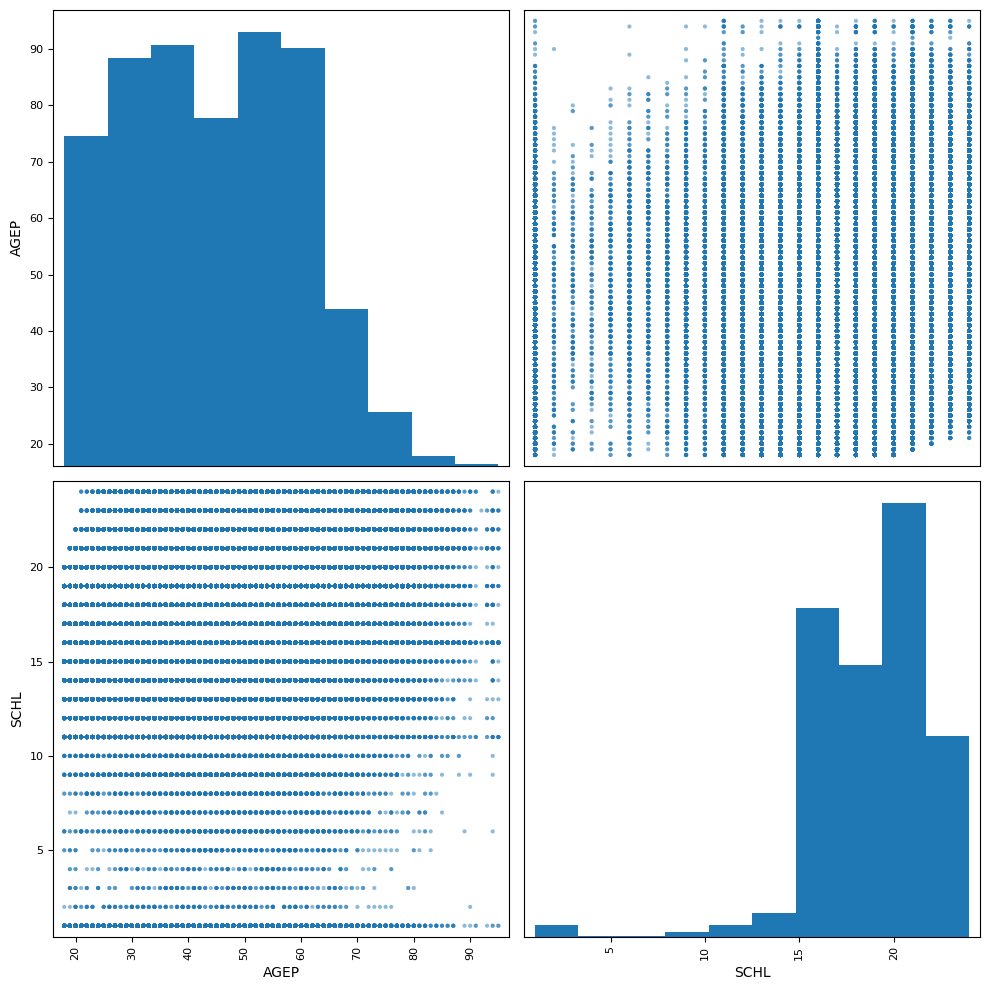

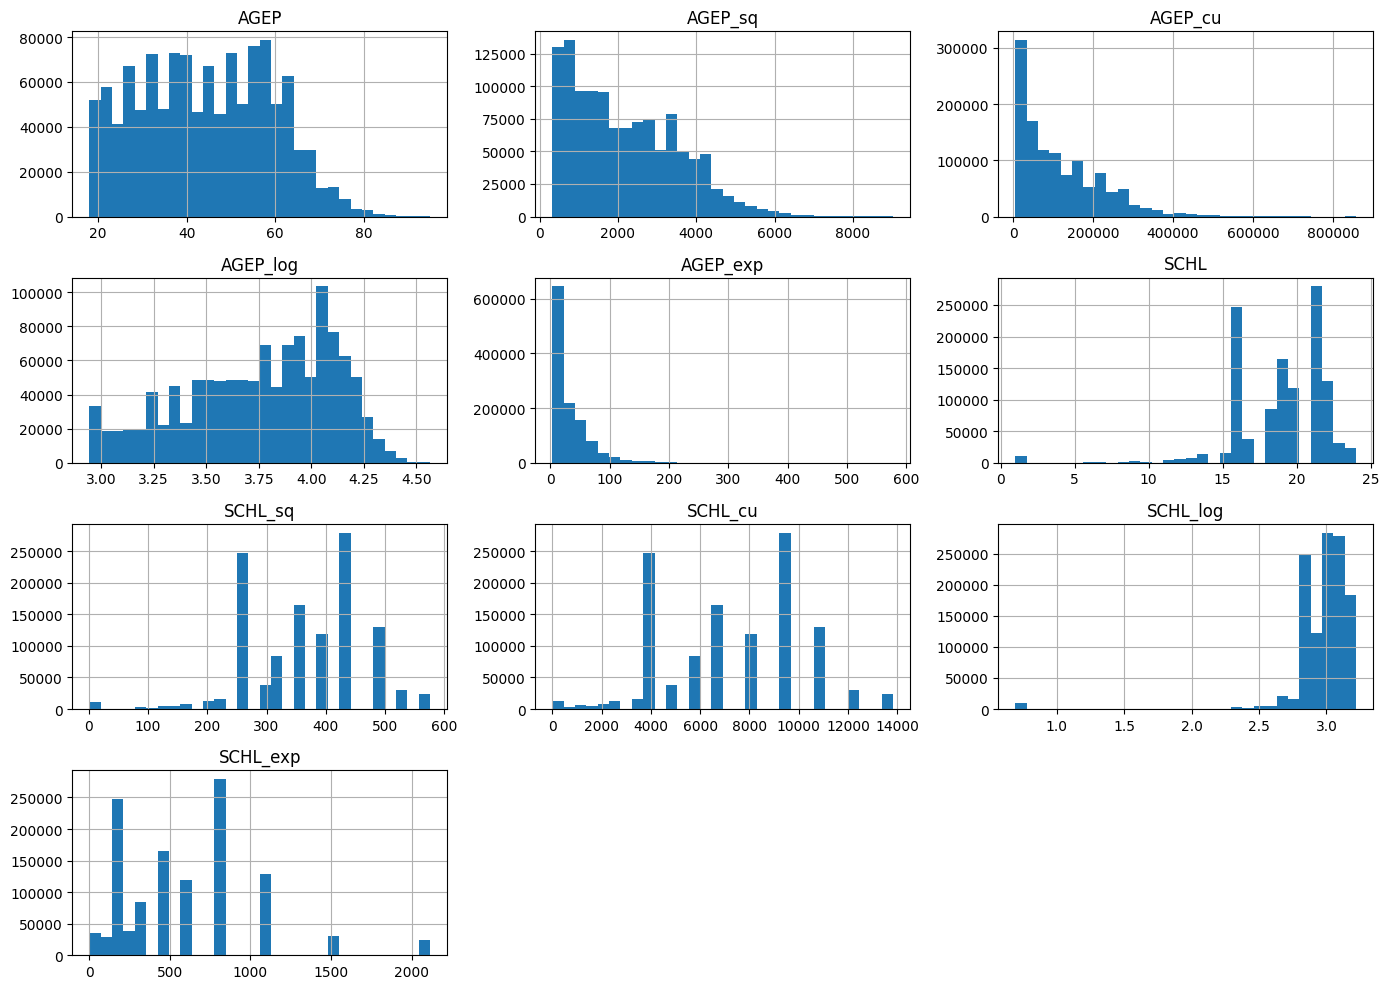

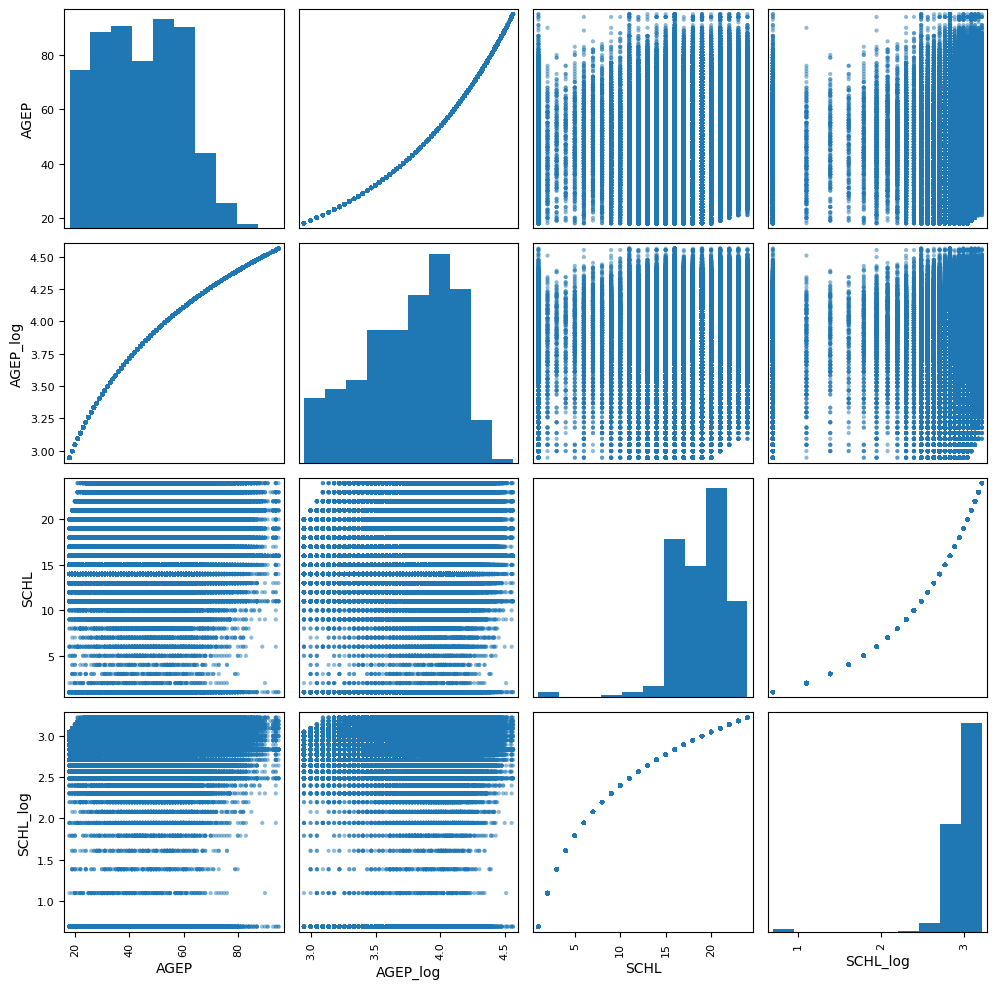

In [1]:
# --------------------- STEP 1 : Setup & download ------------------------
!pip install gdown

import gdown
import pandas as pd
import numpy as np
from pathlib import Path

# --- Paths ---
DATA_DIR = Path(".")
DATA_DIR.mkdir(exist_ok=True)

url = "https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj"
output = DATA_DIR / "psam_pusb.csv"
gdown.download(url, str(output), quiet=False)

PUMS_FILE = output

# --- Columns to load ---
USECOLS = [
    "AGEP",
    "SEX",
    "SCHL",
    "ESR",
    "COW",
    "DIS",
    # "ST",       # will uncomment I i need to read State
    # "REGION",   # will uncomment if I use instead of ST
]

raw_df = pd.read_csv(PUMS_FILE, usecols=USECOLS)
print("Loaded shape:", raw_df.shape)
display(raw_df.head())

available_cols = pd.read_csv(PUMS_FILE, nrows=0).columns.tolist()

if "REGION" not in raw_df.columns and "ST" not in raw_df.columns and "ST" in available_cols:
    raw_df_st = pd.read_csv(PUMS_FILE, usecols=["ST"])
    if len(raw_df_st) == len(raw_df):
        raw_df["ST"] = raw_df_st["ST"]

# Construct REGION from ST
if "REGION" not in raw_df.columns and "ST" in raw_df.columns:
    northeast = {9, 23, 25, 33, 34, 36, 42, 44, 50}
    midwest   = {17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55}
    south     = {1, 5, 10, 11, 12, 13, 21, 22, 24, 28, 37, 40, 45, 47, 48, 51, 54}
    west      = {2, 4, 6, 8, 15, 16, 30, 32, 35, 41, 49, 53, 56}

    def st_to_region(st):
        try:
            st = int(st)
        except Exception:
            return np.nan
        if st in northeast: return 1
        if st in midwest:   return 2
        if st in south:     return 3
        if st in west:      return 4
        return np.nan

    raw_df["REGION"] = raw_df["ST"].map(st_to_region)

# --- Keep adults (18+) & employed civilians (ESR = 1 or 2) ---
if "AGEP" in raw_df.columns and "ESR" in raw_df.columns:
    raw_df = raw_df[(raw_df["AGEP"] >= 18) & (raw_df["ESR"].isin([1, 2]))].copy()

print("After 18+ & employed filter:", raw_df.shape)

# Check for variables missing
for needed in ["AGEP", "SEX", "SCHL", "ESR", "COW", "DIS"]:
    if needed not in raw_df.columns:
        print(f"NOTE: Column '{needed}' not found; it will be dropped if referenced later.")

# --------------------- STEP 2: Train/test split ------------------------------

from sklearn.model_selection import train_test_split

# Label: nonprofit worker (COW = 2)
raw_df["nonprofit_worker"] = (
    raw_df.get("COW", pd.Series([np.nan] * len(raw_df))) == 2
).astype(int)

# Choose variables for feature columns
candidate_features = ["AGEP", "SEX", "SCHL", "DIS"]
feature_cols = [c for c in candidate_features if c in raw_df.columns]
target_col = "nonprofit_worker"

# Drop rows with missing target
df = raw_df.dropna(subset=[target_col]).copy()

# Split features & target
X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))

# ------------- STEP 3: Combine feature and target for inspection -----------

train_df = X_train.copy()
train_df[target_col] = y_train.values

print("DataFrame.info():")
train_df.info()

print("\nDataFrame.describe():")
display(train_df.describe(include="all"))

# ----------- STEP 4: Impute missing values; save cleaned train/test --------

from sklearn.impute import SimpleImputer

numeric_cols = [c for c in ["AGEP", "SCHL"] if c in X_train.columns]
categorical_cols = [c for c in ["SEX", "DIS", "REGION"] if c in X_train.columns]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = (
    pd.DataFrame(num_imputer.fit_transform(X_train[numeric_cols]),
                 columns=numeric_cols, index=X_train.index)
    if numeric_cols else pd.DataFrame(index=X_train.index)
)

X_train_cat = (
    pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_cols]),
                 columns=categorical_cols, index=X_train.index)
    if categorical_cols else pd.DataFrame(index=X_train.index)
)

X_train_clean = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_num = (
    pd.DataFrame(num_imputer.transform(X_test[numeric_cols]),
                 columns=numeric_cols, index=X_test.index)
    if numeric_cols else pd.DataFrame(index=X_test.index)
)

X_test_cat = (
    pd.DataFrame(cat_imputer.transform(X_test[categorical_cols]),
                 columns=categorical_cols, index=X_test.index)
    if categorical_cols else pd.DataFrame(index=X_test.index)
)

X_test_clean = pd.concat([X_test_num, X_test_cat], axis=1)

train_clean_df = X_train_clean.copy()
train_clean_df[target_col] = y_train.values

test_clean_df = X_test_clean.copy()
test_clean_df[target_col] = y_test.values

# Save cleaned data
train_out = DATA_DIR / "pums_train_clean.csv"
test_out = DATA_DIR / "pums_test_clean.csv"

train_clean_df.to_csv(train_out, index=False)
test_clean_df.to_csv(test_out, index=False)

print("Saved to Drive:")
print(" -", train_out)
print(" -", test_out)

# ---------------------- STEP 5: VISUALIZE  ------------ -----------------------

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df["SEX_label"] = df["SEX"].map({1: "Male", 2: "Female"})
df["DIS_label"] = df["DIS"].map({1: "With Disability", 2: "No Disability"})

_ = train_clean_df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

sm_cols = [c for c in ["AGEP", "SCHL"] if c in train_clean_df.columns]
if len(sm_cols) >= 2:
    _ = scatter_matrix(train_clean_df[sm_cols], figsize=(10, 10), diagonal="hist")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for scatter_matrix; skipping.")

# ----------------- STEP 6: TRASNFORM AGEP & SCHL ---------------------------

def safe_log(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def safe_exp(x):
    # avoid overflow
    return np.exp(np.clip(x, a_min=None, a_max=12))

transformed = train_clean_df.copy()

numeric_for_tx = []
for col in ["AGEP", "SCHL"]:
    if col in transformed.columns:
        transformed[f"{col}_sq"]  = transformed[col] ** 2
        transformed[f"{col}_cu"]  = transformed[col] ** 3
        transformed[f"{col}_log"] = safe_log(transformed[col])
        std = transformed[col].std() if transformed[col].std() else 1.0
        transformed[f"{col}_exp"] = safe_exp(transformed[col] / std)
        numeric_for_tx.extend([col, f"{col}_sq", f"{col}_cu", f"{col}_log", f"{col}_exp"])

if numeric_for_tx:
    _ = transformed[numeric_for_tx].hist(figsize=(14, 10), bins=30)
    plt.tight_layout()
    plt.show()

    sm_show = [c for c in ["AGEP", "AGEP_log", "SCHL", "SCHL_log"] if c in transformed.columns]
    if len(sm_show) >= 2:
        _ = scatter_matrix(transformed[sm_show], figsize=(10, 10), diagonal="hist")
        plt.tight_layout()
        plt.show()
else:
    print("AGEP/SCHL not available; skipping transformations.")


# PART 3

Train/Test - only use Training Data (as per assignment)

In [2]:
# use if collab breaks: import pandas as pd
# use if collab breaks: import numpy as np

train_df = pd.read_csv("pums_train_clean.csv")
test_df  = pd.read_csv("pums_test_clean.csv")  # loaded but will not use as per the asingment, might use separately

target_col = "nonprofit_worker"

X_train = train_df.drop(columns=[target_col]).copy()
y_train = train_df[target_col].copy()

print("Training shape:", X_train.shape)
print("Class balance:\n", y_train.value_counts(normalize=True))


Training shape: (1182685, 4)
Class balance:
 nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64


Categorical variables and scale numerics

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_cols = [c for c in ["AGEP","SCHL"] if c in X_train.columns]
cat_cols     = [c for c in ["SEX","DIS","REGION"] if c in X_train.columns]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])


PCA

Components needed for 95% variance: 4


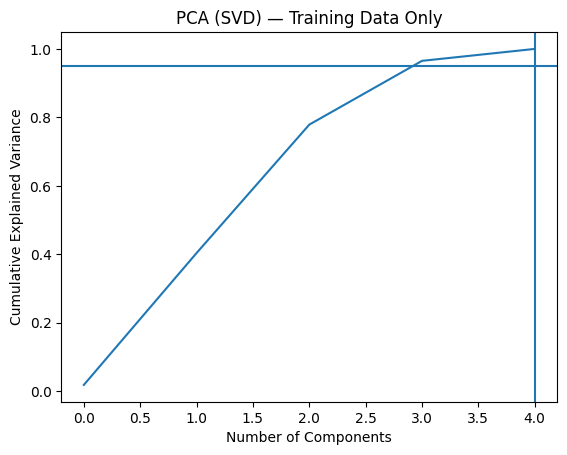

In [4]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

X_train_proc = preprocess.fit_transform(X_train)

max_components = min(200, X_train_proc.shape[1] - 1)
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_train_proc)

cum_var = np.cumsum(svd_full.explained_variance_ratio_)
k95 = int(np.argmax(cum_var >= 0.95) + 1)

print("Components needed for 95% variance:", k95)

plt.figure()
plt.plot(cum_var)
plt.axhline(0.95)
plt.axvline(k95)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA (SVD) — Training Data Only")
plt.show()


PCA on best model (Random Forest (balanced))

In [7]:
# Best model from Projct_1(2)

np.random.seed(42)

sample_n = 30000
idx = np.random.choice(len(X_train), sample_n, replace=False)

X_train_sub = X_train.iloc[idx]
y_train_sub = y_train.iloc[idx]

print("Subsample shape:", X_train_sub.shape)
print("Class balance:\n", y_train_sub.value_counts(normalize=True))


Subsample shape: (30000, 4)
Class balance:
 nonprofit_worker
0    0.891533
1    0.108467
Name: proportion, dtype: float64


PCA mdoel improvement

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

svd_model = Pipeline([
    ("preprocess", preprocess),
    ("svd", TruncatedSVD(n_components=k95, random_state=42)),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

baseline_f1 = cross_val_score(
    baseline_model, X_train_sub, y_train_sub, cv=cv, scoring="f1"
)

svd_f1 = cross_val_score(
    svd_model, X_train_sub, y_train_sub, cv=cv, scoring="f1"
)

print(f"Baseline model (no PCA) – mean F1: {baseline_f1.mean():.4f}, "
      f"std: {baseline_f1.std():.4f}")

print(f"Model with PCA (95% variance) – mean F1: {svd_f1.mean():.4f}, "
      f"std: {svd_f1.std():.4f}")

print(f"Difference in mean F1 (PCA − no PCA): {(svd_f1.mean() - baseline_f1.mean()):.4f}")



Baseline model (no PCA) – mean F1: 0.2528, std: 0.0049
Model with PCA (95% variance) – mean F1: 0.2520, std: 0.0049
Difference in mean F1 (PCA − no PCA): -0.0007


Cluster Analysis

In [9]:
# Hleper Function

from sklearn.metrics import adjusted_rand_score, silhouette_score

def cluster_scores(X, labels, y):
    ari = adjusted_rand_score(y, labels)
    if len(set(labels)) < 2 or len(set(labels)) == 1:
        sil = np.nan
    else:
        mask = labels != -1
        sil = silhouette_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan
    return ari, sil


In [10]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_vis_2d = svd_2d.fit_transform(X_train_proc)


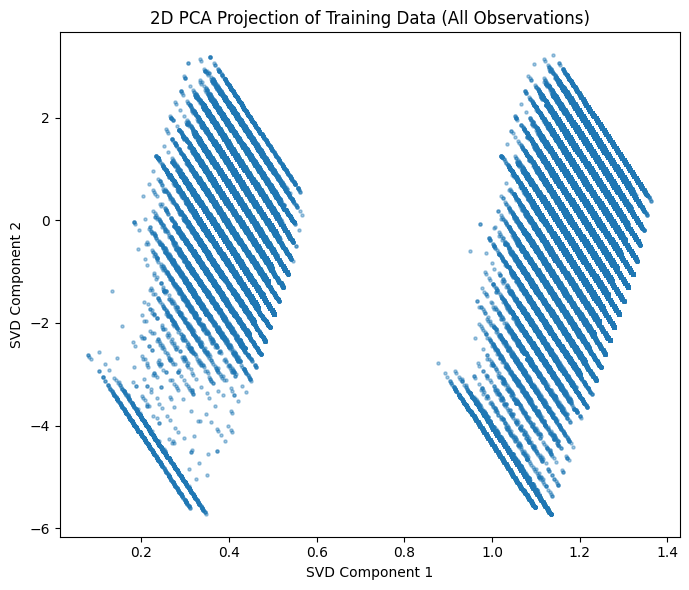

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    X_vis_2d[:, 0],
    X_vis_2d[:, 1],
    s=5,
    alpha=0.4
)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D PCA Projection of Training Data (All Observations)")
plt.tight_layout()
plt.show()


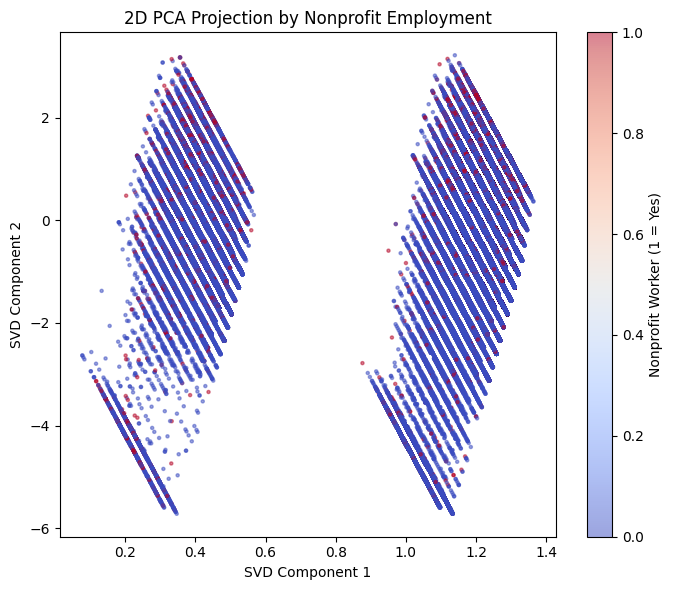

In [28]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_vis_2d[:, 0],
    X_vis_2d[:, 1],
    c=y_train,
    cmap="coolwarm",
    s=5,
    alpha=0.5
)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D PCA Projection by Nonprofit Employment")
plt.colorbar(scatter, label="Nonprofit Worker (1 = Yes)")
plt.tight_layout()
plt.show()


K-Means

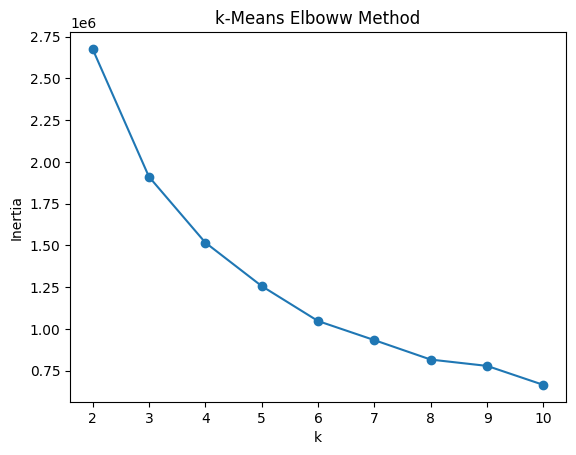

In [27]:
from sklearn.cluster import KMeans

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_train_proc)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("k-Means Elboww Method")
plt.show()


K-Means without PCA

In [14]:
# reduced and used subsample due to high computation needs (collab)

# use if collab breaks import numpy as np

np.random.seed(42)

sample_n = 30000
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_km = X_train_proc[idx]
y_km = y_train.iloc[idx]


In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_km)

ari_km, sil_km = cluster_scores(X_km, labels_km, y_km)
print("k-Means (no PCA) ARI:", ari_km, "Silhouette:", sil_km)


k-Means (no PCA) ARI: -0.00068196216662195 Silhouette: 0.330641570367984


K-Means with PCA

In [16]:
# import numpy as np
np.random.seed(42)

sample_n = 30000  # try lower if too slwo fo ryou professor (google collab laoding time varried)
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_sub = X_train_proc[idx]
y_sub = y_train.iloc[idx]


In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# chosen components
svd_k = min(20, X_sub.shape[1] - 1)  # must be <= n_features-1
print("n_features:", X_sub.shape[1], " -> using svd_k:", svd_k)

X_svd = TruncatedSVD(n_components=svd_k, random_state=42).fit_transform(X_sub)

kmeans_pca = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels_km_pca = kmeans_pca.fit_predict(X_svd)

ari_km_pca, sil_km_pca = cluster_scores(X_svd, labels_km_pca, y_sub)
print(f"k-Means (SVD={svd_k}) ARI:", ari_km_pca, "Silhouette:", sil_km_pca)



n_features: 6  -> using svd_k: 5
k-Means (SVD=5) ARI: -0.00068196216662195 Silhouette: 0.3306415703878333


In [18]:
print("X_train_proc shape:", X_train_proc.shape)
print("X_sub shape:", X_sub.shape)


X_train_proc shape: (1182685, 6)
X_sub shape: (30000, 6)


Agglomerative/Hierarchical Clustering

In [19]:
# No PCA

from sklearn.cluster import AgglomerativeClustering
import numpy as np

np.random.seed(42)

sample_n = min(30000, X_train_proc.shape[0])
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_s = X_train_proc[idx]
y_s = y_train.iloc[idx].to_numpy()

agg = AgglomerativeClustering(n_clusters=6)
labels_agg = agg.fit_predict(X_s)

ari_agg, sil_agg = cluster_scores(X_s, labels_agg, y_s)
print("Agglomerative (no PCA) ARI:", ari_agg, "Silhouette:", sil_agg)



Agglomerative (no PCA) ARI: 0.0060236576759913965 Silhouette: 0.25421860534309415


In [20]:
# PCA

from sklearn.decomposition import TruncatedSVD

svd_k = min(5, X_s.shape[1] - 1)
X_s_pca = TruncatedSVD(n_components=svd_k, random_state=42).fit_transform(X_s)

agg_pca = AgglomerativeClustering(n_clusters=6)
labels_agg_pca = agg_pca.fit_predict(X_s_pca)

ari_agg_pca, sil_agg_pca = cluster_scores(X_s_pca, labels_agg_pca, y_s)
print("Agglomerative (PCA) ARI:", ari_agg_pca, "Silhouette:", sil_agg_pca)


Agglomerative (PCA) ARI: -0.003962716624913207 Silhouette: 0.26521978767914556


In [21]:
# DBScan

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=20)
labels_db = db.fit_predict(X_sub)

ari_db, sil_db = cluster_scores(X_sub, labels_db, y_sub)
print("DBSCAN (no PCA) ARI:", ari_db, "Silhouette:", sil_db)



DBSCAN (no PCA) ARI: 0.006869786246461949 Silhouette: 0.26586973828581456


In [22]:
db_pca = DBSCAN(eps=1.2, min_samples=20)
labels_db_pca = db_pca.fit_predict(X_svd)

ari_db_pca, sil_db_pca = cluster_scores(X_svd, labels_db_pca, y_sub)
print(f"DBSCAN (SVD={svd_k}) ARI:", ari_db_pca, "Silhouette:", sil_db_pca)


DBSCAN (SVD=5) ARI: 0.007304824701226716 Silhouette: 0.2553165258132319


In [23]:
results = pd.DataFrame({
    "Method": ["kMeans","kMeans","Agglomerative","Agglomerative","DBSCAN","DBSCAN"],
    "PCA": ["No", f"Yes (SVD={svd_k})", "No", f"Yes (SVD={svd_k})", "No", f"Yes (SVD={svd_k})"],
    "ARI": [ari_km, ari_km_pca, ari_agg, ari_agg_pca, ari_db, ari_db_pca],
    "Silhouette": [sil_km, sil_km_pca, sil_agg, sil_agg_pca, sil_db, sil_db_pca]
})

results


,Method,PCA,ARI,Silhouette
0,kMeans,No,-0.000682,0.330642
1,kMeans,Yes (SVD=5),-0.000682,0.330642
2,Agglomerative,No,0.006024,0.254219
3,Agglomerative,Yes (SVD=5),-0.003963,0.265220
4,DBSCAN,No,0.006870,0.265870
5,DBSCAN,Yes (SVD=5),0.007305,0.255317


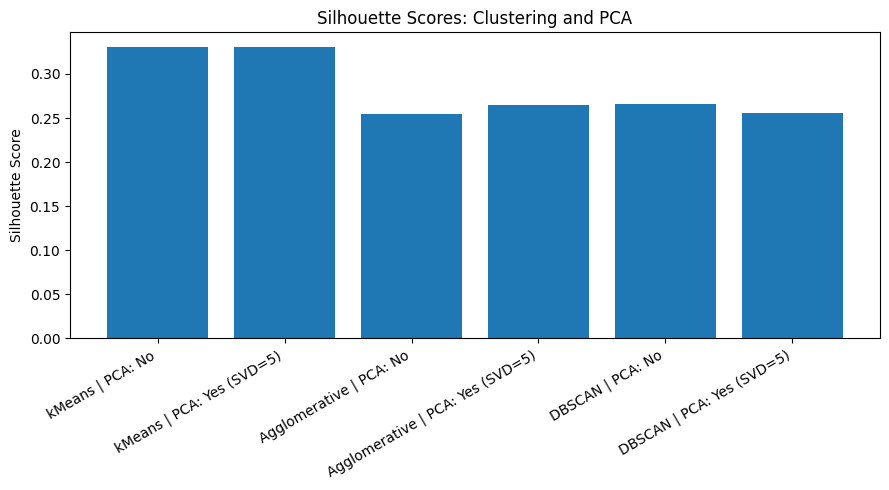

In [26]:
import matplotlib.pyplot as plt

results_plot = results.copy()
results_plot["Label"] = results_plot["Method"] + " | PCA: " + results_plot["PCA"]

plt.figure(figsize=(9, 5))
plt.bar(results_plot["Label"], results_plot["Silhouette"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores: Clustering and PCA")
plt.tight_layout()
plt.show()
